In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# torchvision : 딥러닝에 사용하는 dataset을 가지는 모듈

from matplotlib import pyplot as plt

### Cuda(GPU) 가능 여부 및 Cuda 사용 불가 시 cpu 설정

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cpu


### 파라미터 설정

In [4]:
batch_size = 50
# data = 60k, batch_size = 50, data_bundle(묶음) = 1.2k
learning_rate = 0.0001
epoch_num = 15

### 데이터 불러오기

In [6]:
train_data = datasets.MNIST(
    root='./data/', # 저장 경로
    train=True, # train data 여부, False 시 test로 인식
    download=True, # 최초 한번만 다운로드 받고 추후 False 시 지정된 경로의 data를 사용하겠다는 설정
    transform=transforms.ToTensor() # 바로 Tensor로 바꿔주는 설정
)

test_data = datasets.MNIST(
    root='./data/',
    train=False,
    transform=transforms.ToTensor()
)

print('number of traning data :', len(train_data))
print('number of test data :', len(test_data))

100%|██████████| 9912422/9912422 [00:01<00:00, 5427013.66it/s]


Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 2648816.89it/s]


Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1946469.39it/s]


Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw

number of traning data : 60000
number of test data : 10000


In [8]:
image, label = train_data[0]

image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

### 2차원 확인

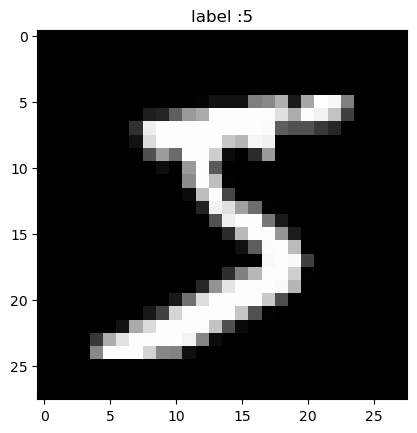

In [9]:
plt.imshow(image.squeeze().numpy(), cmap='gray')
# .squeeze() : [1, 28, 28] 데이터를 1을 지우고 가로, 세로의 2차원의 형태로 바꿔주는 메써드
# torchvision 모듈에서 가져온 dataset의 MNIST 데이터의 한세트는 이미 처음부터 CNN 모델을 고려하여 [1, 28, 28] 형태로 이미 바뀌어져 있다
# keras모듈의 경우 이를 [28, 28, 1] 과 같이 수정해주었어야 했다
plt.title('label :%s' % label)
plt.show()

### mini batch 구성
### torch.utils.data.DataLoader
- PyTorch에서 데이터를 미니배치로 나누어 학습 루프에서 사용하기 쉽게 만들어주는 유틸리티 클래스 
- 이를 사용하면 데이터를 일괄(batch)로 가져오고, 셔플(shuffle), 병렬 로딩(parallel loading) 등의 다양한 기능을 제공 가능
- shuffle : 데이터의 순서를 학습하는 것을 방지

In [11]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()

In [14]:
print('{:15s} \ {:<25s} \ {}'.format('name', 'type', 'size'))
# :15s : 15 글자칸을 확보해둬라
# < : 왼쪽 정렬
print('{:15s} \ {:<25s} \ {}'.format('Num of batch', '', len(train_loader)))
print('{:15s} \ {:<25s} \ {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} \ {:<25s} \ {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
                                    # first_batch[0] : 데이터
print('{:15s} \ {:<25s} \ {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))
                                    # first_batch[1] : 라벨


name            \ type                      \ size
Num of batch    \                           \ 1200
first_batch     \ <class 'list'>            \ 2
first_batch[0]  \ <class 'torch.Tensor'>    \ torch.Size([50, 1, 28, 28])
first_batch[1]  \ <class 'torch.Tensor'>    \ torch.Size([50])


### torch.nn.functional.log_softmax

- Softmax 함수: 주어진 벡터를 입력으로 받아, 각 요소의 지수를 계산하고, 이를 정규화하여 모든 요소의 합이 1이 되도록 만드는 함수입니다. 
- Softmax 함수는 주로 다중 클래스 분류 문제에서 출력 확률을 계산하는 데 사용됩니다.

- Log-softmax 함수: Softmax 함수의 출력을 취해 로그를 취한 것입니다. 로그를 취함으로써 수치적 안정성(numerical stability)이 향상되고, 
- 학습 중에 발생할 수 있는 소수점 계산 오류를 감소시킬 수 있습니다. 수학적으로는 log(softmax(x))와 동일합니다.

- 이 함수는 입력 텐서를 받아 지정된 차원(dim)을 기준으로 log-softmax를 계산합니다. 주로 손실 함수 계산이나 모델의 출력을 확률로 변환할 때 사용됩니다.

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding='same')
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
        self.dropout = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(3136, 1000)
        # 28 * 28 데이터가 아래와 같이 2로 풀링 되어 14 * 14로, 
        # 풀링된 14 * 14가 다시 2로 풀링되어 7 * 7로 되어
        # 마지막 레이어의 채널 숫자인 64를 곱하게 되어 7 * 7 * 64 = 3136개의 입력값을 가지게 된다
        # 계산이 복잡할 시 일단 코딩을 해보고 error메세지를 확인하면 값을 알려준다
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

### 학습

In [22]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [23]:
model.train() # 학습을 하겠다는 선언, 별도 기능은 없음
i = 1
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data) #data : 하나의 batch
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('Train Step : {}\tLoss : {:.3f}'.format(i, loss.item()))

        i += 1


Train Step : 1000	Loss : 0.210
Train Step : 2000	Loss : 0.039
Train Step : 3000	Loss : 0.078
Train Step : 4000	Loss : 0.037
Train Step : 5000	Loss : 0.021
Train Step : 6000	Loss : 0.024
Train Step : 7000	Loss : 0.060
Train Step : 8000	Loss : 0.009
Train Step : 9000	Loss : 0.025
Train Step : 10000	Loss : 0.003
Train Step : 11000	Loss : 0.004
Train Step : 12000	Loss : 0.077
Train Step : 13000	Loss : 0.002
Train Step : 14000	Loss : 0.003
Train Step : 15000	Loss : 0.017
Train Step : 16000	Loss : 0.002
Train Step : 17000	Loss : 0.001
Train Step : 18000	Loss : 0.004


### 테스트

In [29]:
model.eval() # 테스트 하겠다는 선언, dropout 기능은 자동으로 꺼짐
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('Test set : Accurancy : {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Test set : Accurancy : 99.08%
